In [2]:
## Optional if you already run ./down_viecap.sh
# !pip install gdown
# !gdown https://drive.google.com/uc?id=1lbOTlksNA5a97_Ydqh84TE6Dm85Rsy60
# !gdown https://drive.google.com/uc?id=1lKqdtekrhzlf7duVs34IQPVLROowoLoR
# !gdown https://drive.google.com/uc?id=1rCDniCZNgaJ7WQUzPpzEwuXW5_WNyave
# !unzip viecap4h-public-train.zip
# !unzip vietcap4h-public-test.zip
# !unzip -qq viecap4h-public-train/images_train.zip
# !unzip -qq vietcap4h-public-test/images_public_test.zip
# !unzip -qq vietcap4h-private-test.zip
# !mkdir viecap
# !mv images_train viecap
# !mv images_public_test viecap
# !mv vietcap4h-private-test/images viecap/images_private_test
# !mv vietcap4h-private-test/private_sample_sub.json viecap
# !mv viecap4h-public-train/train_captions.json viecap
# !mv vietcap4h-public-test/sample_submission.json viecap
# !rm *.zip
# !rm -rf viecap4h-public-train/
# !rm -rf vietcap4h-public-test/
# !pip install git+https://github.com/openai/CLIP.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14262 sha256=a1157886da6dc692f94325c3f48c44ee66205e41c33a5349a6afeb033ab6daff
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
Successfully built gdown
Downloading...
From: https://drive.google.com/uc?id=1lbOTlksNA5a97_Ydqh84TE6Dm85Rsy60
To: /kaggle/working/viecap4h-public-train.zip
100%|█████████████████████████████████████████| 982M/982M [00:09<00:00, 109MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lKqdtekrhzlf7duVs34IQPVLROowoLoR
To: /kaggle/working/vietcap4h-public-test.zip
100%|████████████████████████████████████████| 122M/122M [00:01<00:00, 80.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rCDniCZNgaJ7WQUzPpzEwuXW5_WNyave
To: /kaggle/working/vietcap4h-private-test.zip
100%|██████████████████████████████

In [3]:
import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image 


N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device(0)

# current_directory = os.getcwd()
# save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
# os.makedirs(save_path, exist_ok=True)
# model_path = os.path.join(save_path, 'model_wieghts.pt')


class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
#                 layers.append(nn.Dropout(p=0.1))
                layers.append(nn.Dropout(p=0.2)) # update 17/10 20:00PM

        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        #print(embedding_text.size()) #torch.Size([5, 67, 768])
        #print(prefix_projections.size()) #torch.Size([5, 1, 768])
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self
    

def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
#     stop_token_index = tokenizer.encode(stop_token)[0]
    stop_token_index = 0

    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

#@title GPU/CPU

is_gpu = True #@param {type:"boolean"}  
from transformers import AutoTokenizer

#@title CLIP model + GPT2 tokenizer

device = CUDA
clip_model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
tokenizer = AutoTokenizer.from_pretrained("imthanhlv/gpt2news")

from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
import os
from glob import glob

100%|████████████████████████████████████████| 335M/335M [00:03<00:00, 112MiB/s]


Downloading:   0%|          | 0.00/831 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [4]:
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
#     stop_token_index = 0

    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [ ]:
!rm *.pt

In [5]:
# !wget https://transfer.sh/MKg0vi/nmt-011-x3b16.pt - 0.3
# !wget https://transfer.sh/IxFmUV/nmt-013-x3b16.pt - 0.301
# !wget https://transfer.sh/GnnGQ3/nmt-015-x3b16.pt - 0.310
# !wget https://transfer.sh/get/vDn7lo/nmt-017-x3b16.pt - 0.302
# !wget https://transfer.sh/HlEAVL/iwlts-nmt-012-x3b16.pt
# !wget https://transfer.sh/hs7CMM/iwlts05.pt
!wget https://transfer.sh/ca68Sr/iwlts-nmt-015-x3b16.pt # - 0.313
# !wget https://transfer.sh/tua9MO/iwlts-nmt-020-x3b16.pt - bad
# !wget https://transfer.sh/BV0PL0/iwlts-nmt-014-x3b16.pt
# !wget https://transfer.sh/Wq9LhK/iwlts-nmt-017-x3b16.pt - 0.304
# !wget https://transfer.sh/fl9YfA/all-017-x3b16.pt
# !wget https://transfer.sh/Dj27Ny/all-014-x3b16.pt

--2021-10-20 03:27:24--  https://transfer.sh/ca68Sr/iwlts-nmt-015-x3b16.pt
Resolving transfer.sh (transfer.sh)... 144.76.136.153
Connecting to transfer.sh (transfer.sh)|144.76.136.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 790665448 (754M) []
Saving to: ‘iwlts-nmt-015-x3b16.pt’

iwlts-nmt-015-x3b16 100%[===================>] 754.04M  23.5MB/s    in 35s     

2021-10-20 03:28:00 (21.8 MB/s) - ‘iwlts-nmt-015-x3b16.pt’ saved [790665448/790665448]

--2021-10-20 03:28:00--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2021-10-20 03:28:00--  http://0.313/
Resolving 0.313 (0.313)... 0.0.1.57
Connecting to 0.313 (0.313)|0.0.1.57|:80... ^C


In [6]:
prefix_length = 10

# model = ClipCaptionModel(prefix_length)
model = ClipCaptionPrefix(prefix_length)

# model_path = "./checkpoints/viecap_prefix_both-010.pt"
# model_path = "./nmt-040.pt"
# model_path = "./nmt-028-merge.pt" # - 0.298
# model_path = "./nmt-020-merge.pt" - 0.289
# model_path = "./nmt-012-merge.pt"
# model_path = "./nmt-011-x3b16.pt" # - 0.3
# model_path = "./nmt-013-x3b16.pt" # - 0.301
# model_path = "./nmt-015-x3b16.pt" # 0.310
# model_path = "./nmt-017-x3b16.pt"
# model_path = "./iwlts05.pt"
model_path = "./iwlts-nmt-015-x3b16.pt" # 0.313
# model_path = "./iwlts-nmt-020-x3b16.pt"
# model_path = "./iwlts-nmt-014-x3b16.pt"
# model_path = "./iwlts-nmt-017-x3b16.pt"
# model_path = "./iwlts-nmt-012-x3b16.pt"
# model_path = "./all-017-x3b16.pt"
# model_path = "./all-014-x3b16.pt"

model.load_state_dict(torch.load(model_path, map_location=CPU)) 

model = model.eval() 
device = CUDA
# model_path = "./nmt-015-x3b16.pt"
model = model.to(device)

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [7]:
!ls

__MACOSX		   iwlts-nmt-015-x3b16.pt  vietcap4h-private-test
__notebook_source__.ipynb  viecap


# Public test

In [ ]:
out = []

embeddings = []
ids = []


test = False
for filename in tqdm(sorted(glob("./viecap/images_public_test/*"))):
# test = True
# for filename in sorted(glob("./viecap/images_public_test/*"))[:20]:
    # image = io.imread(UPLOADED_FILE)
    # # pil_image = PIL.Image.fromarray(image)
    # # pil_img = Image(filename=UPLOADED_FILE)
    pil_img = Image.open(filename)
    image = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed, temperature=1, beam_size=15)[0]

    if test:
        display(pil_img)
        print(generated_text_prefix)
    # if use_beam_search:
    # else:
    #     generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    out.append({
        "id": os.path.split(filename)[-1],
        "captions": generated_text_prefix
    })
    
    embeddings.append(prefix)
    ids.append(os.path.split(filename)[-1])

import json

!rm *.json
!rm *.zip

sub = {i["id"]: i["captions"] for i in out}
sample = json.load(open("./viecap/sample_submission.json", "r"))
for i in sample:
    i["captions"] = sub[i["id"]].split("\n")[0]


with open("./results.json", "w") as f:
    json.dump(sample, f, ensure_ascii=False)

!zip -9r submission.zip results.json
!curl --upload-file ./submission.zip https://transfer.sh/submission.zip

# Private test

In [11]:
out = []

embeddings = []
ids = []


test = False
for filename in tqdm(sorted(glob("./viecap/images_private_test/*"))):
# test = True
# for filename in sorted(glob("./viecap/images_private_test/*"))[:40]:
    # image = io.imread(UPLOADED_FILE)
    # # pil_image = PIL.Image.fromarray(image)
    # # pil_img = Image(filename=UPLOADED_FILE)
    pil_img = Image.open(filename)
    image = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        # if type(model) is ClipCaptionE2E:
        #     prefix_embed = model.forward_image(image)
        # else:
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)
        generated_text_prefix = generate_beam(model, tokenizer, embed=prefix_embed, temperature=1, beam_size=15)[0]

    if test:
        display(pil_img)
        print(generated_text_prefix)
    # if use_beam_search:
    # else:
    #     generated_text_prefix = generate2(model, tokenizer, embed=prefix_embed)
    out.append({
        "id": os.path.split(filename)[-1],
        "captions": generated_text_prefix
    })
    
    embeddings.append(prefix)
    ids.append(os.path.split(filename)[-1])

100%|██████████| 1034/1034 [06:35<00:00,  2.62it/s]


In [12]:
import json

!rm *.json
!rm *.zip

sub = {i["id"]: i["captions"] for i in out}
sample = json.load(open("./viecap/private_sample_sub.json", "r"))
for i in sample:
    i["captions"] = sub[i["id"]].split("\n")[0]


with open("./results.json", "w") as f:
    json.dump(sample, f, ensure_ascii=False)

!zip -9r submission.zip results.json
!curl --upload-file ./submission.zip https://transfer.sh/submission.zip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
rm: cannot remove '*.json': No such file or directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
rm: cannot remove '*.zip': No such file or directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	-

In [23]:
torch.save({"clip_embedding": embeddings, "test_id": ids}, "test_b16.pt")

In [28]:
!rm test_b16.pt
# !wget https://transfer.sh/1JB1DQ/data_16.zip
!unzip data_16.zip
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
rm: cannot remove 'test_b16.pt': No such file or directory
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Archive:  data_16.zip
  inflating: test_b16.pt             
  inflating: text_b16.pt             
  inflating: train_img_b16.pt        
  inflating: val_img_b16.pt          
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling paralle

In [29]:
train = torch.load("./train_img_b16.pt")


In [30]:
train.keys()

dict_keys(['clip_embedding', 'target'])

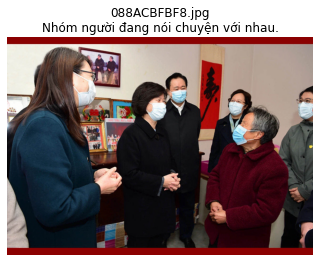

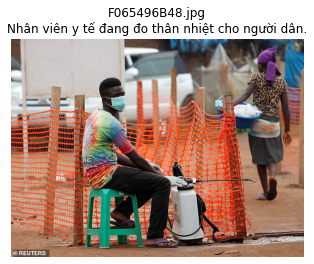

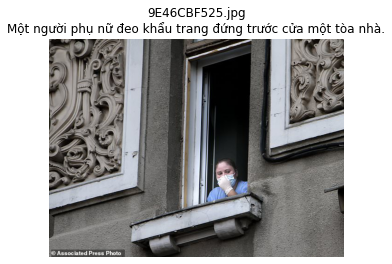

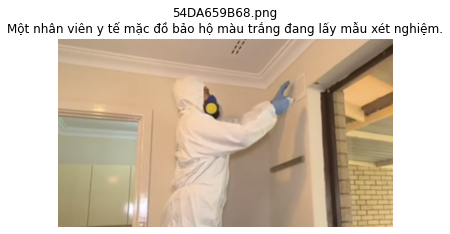

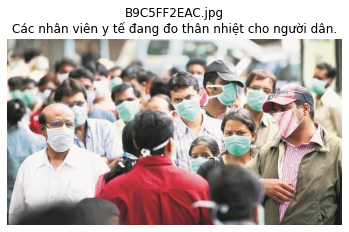

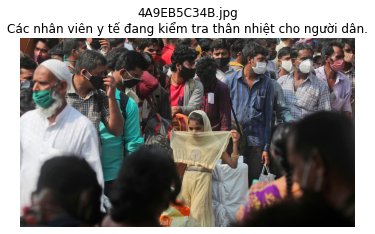

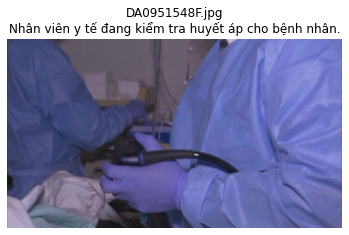

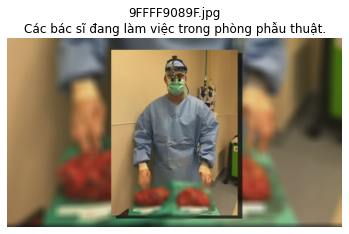

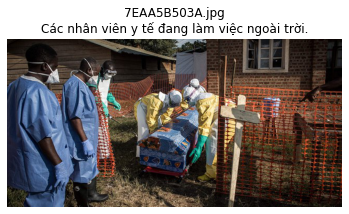

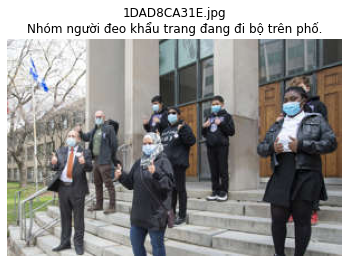

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

for i in sample[20:30]:
    id, cap = i['id'], i['captions']
    img = "./viecap/images_private_test/" + id
    plt.figure()
    plt.imshow(np.asarray(Image.open(img)))
    plt.axis('off')
    plt.title(id + "\n" + cap)